# Artificial Neural Networks and Deep Learning

---

## Lecture 7a: Timeseries Classification

<img src="https://drive.google.com/uc?export=view&id=1URwMSSlsgI716DsPSQVJXhll3vaPgL7v" width="500"/>

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Lecture 6

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load and Process Data

In [2]:
# Set environment variables for Activity Recognition dataset
os.environ["DATASET_NAME"] = "activities_recognition.txt"
os.environ["DATASET_URL"] = "1QqyAJndGqPa-pWgyI63SuBAT__GnmL1b"

# Check if Activity Recognition dataset exists, download and unzip if not
if not os.path.exists(os.environ["DATASET_NAME"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${DATASET_URL} -O ${DATASET_NAME}
    print("Activity Recognition dataset downloaded!")
else:
    print("Activity Recognition dataset already downloaded. Using cached data.")

Activity Recognition dataset downloaded!


In [3]:
# Define column names for the dataset
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

# Read the dataset into a DataFrame with specified column names
df = pd.read_csv('activities_recognition.txt', header=None, names=column_names)

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Display the first 10 rows of the DataFrame
df.head(10)

DataFrame shape: (1098208, 6)


,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [4]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x_axis     1098208 non-null  float64
 4   y_axis     1098208 non-null  float64
 5   z_axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [5]:
# Convert 'x_axis' column to float32 data type
df['x_axis'] = df['x_axis'].astype(np.float32)

# Convert 'y_axis' column to float32 data type
df['y_axis'] = df['y_axis'].astype(np.float32)

# Convert 'z_axis' column to float32 data type
df['z_axis'] = df['z_axis'].astype(np.float32)

# Display updated DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x_axis     1098208 non-null  float32
 4   y_axis     1098208 non-null  float32
 5   z_axis     1098208 non-null  float32
dtypes: float32(3), int64(2), object(1)
memory usage: 46.1+ MB


In [6]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

,user_id,timestamp,x_axis,y_axis,z_axis
count,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06
mean,1.886067e+01,3.340895e+13,6.628657e-01,7.255626e+00,4.110785e-01
std,1.021423e+01,4.944962e+13,6.846455e+00,6.744223e+00,4.752265e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,2.019110e+12,-2.870000e+00,3.170000e+00,-2.220000e+00
50%,1.900000e+01,9.722677e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,4.996560e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


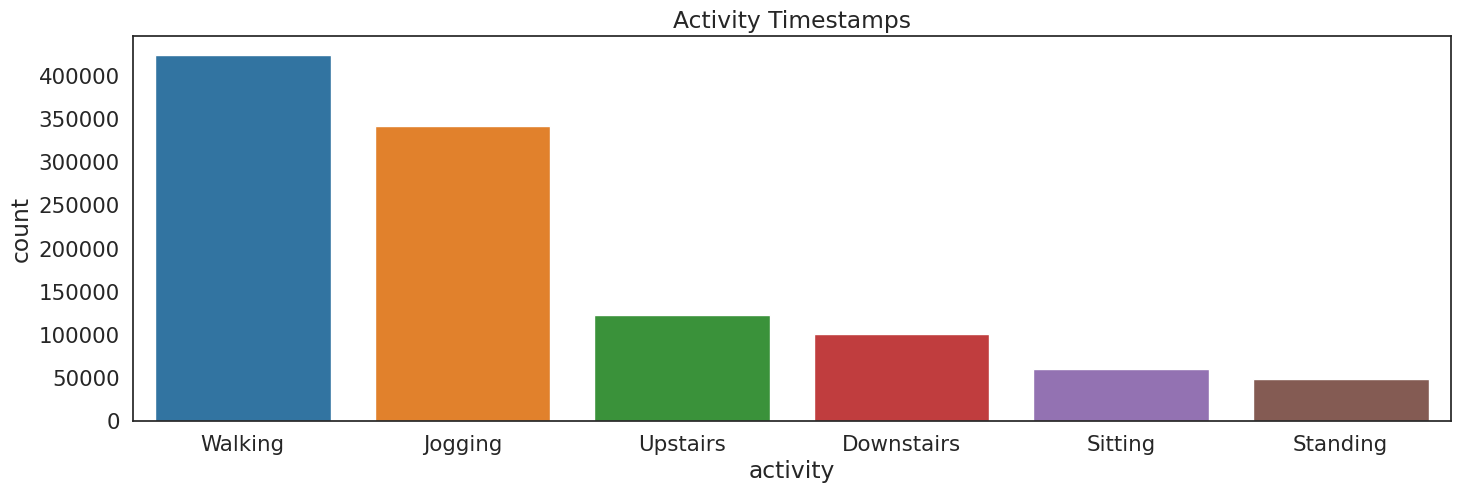

In [7]:
# Visualise the count of timestamps for each activity
plt.figure(figsize=(17, 5))
sns.countplot(
    x='activity',
    data=df,
    order=df['activity'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Activity Timestamps')

# Display the plot
plt.show()

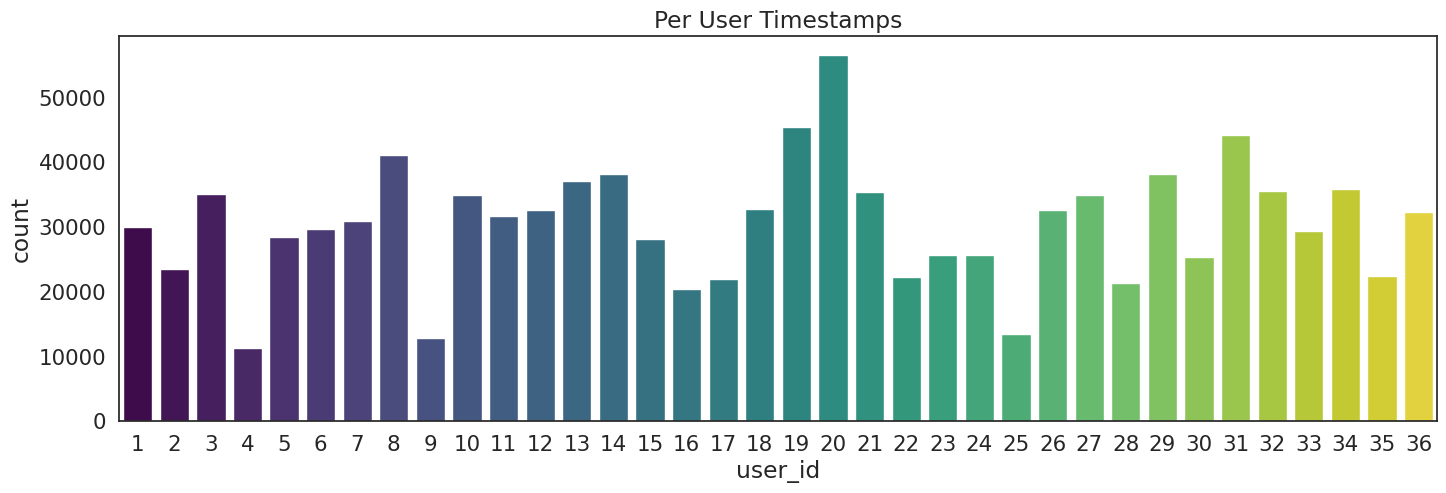

In [8]:
# Count the number of unique users
n_users = len(df['user_id'].unique())

# Create a custom colour map with distinct colours for each user
colors = plt.cm.viridis(np.linspace(0, 1, n_users))

# Visualise the count of timestamps for each user
plt.figure(figsize=(17, 5))
sns.countplot(
    x='user_id',
    data=df,
    palette=colors
)

# Set the title of the plot
plt.title('Per User Timestamps')

# Display the plot
plt.show()

In [9]:
# Define a function to inspect sensor data for a specific activity
def inspect_activity(activity, df):
    # Filter the DataFrame for the specified activity and limit to 500 rows
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:500]

    # Plot the sensor data for each axis
    axis = data.plot(subplots=True, figsize=(17, 9), title=activity)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')

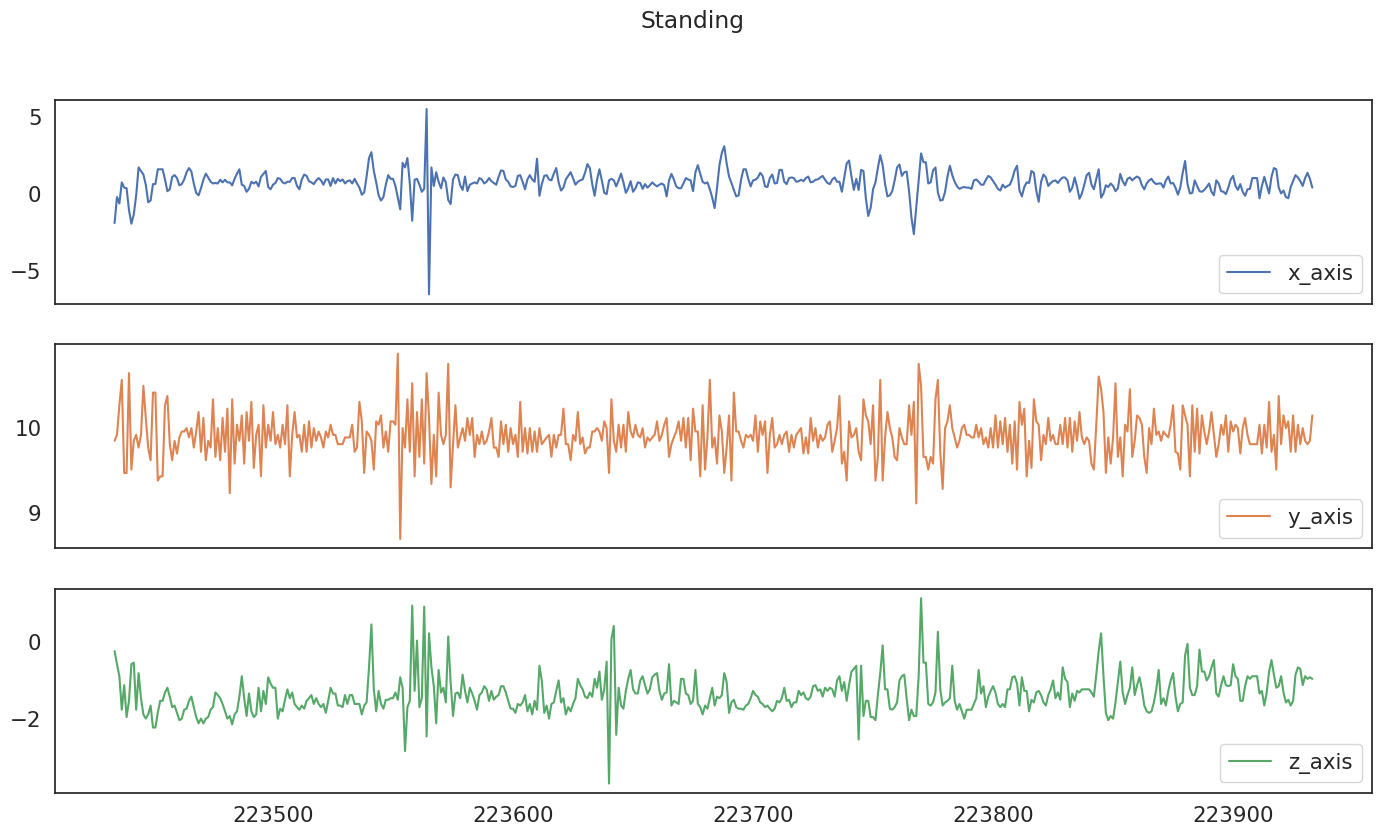

In [10]:
# Inspect the sensor data for the activity "Standing"
inspect_activity("Standing", df)

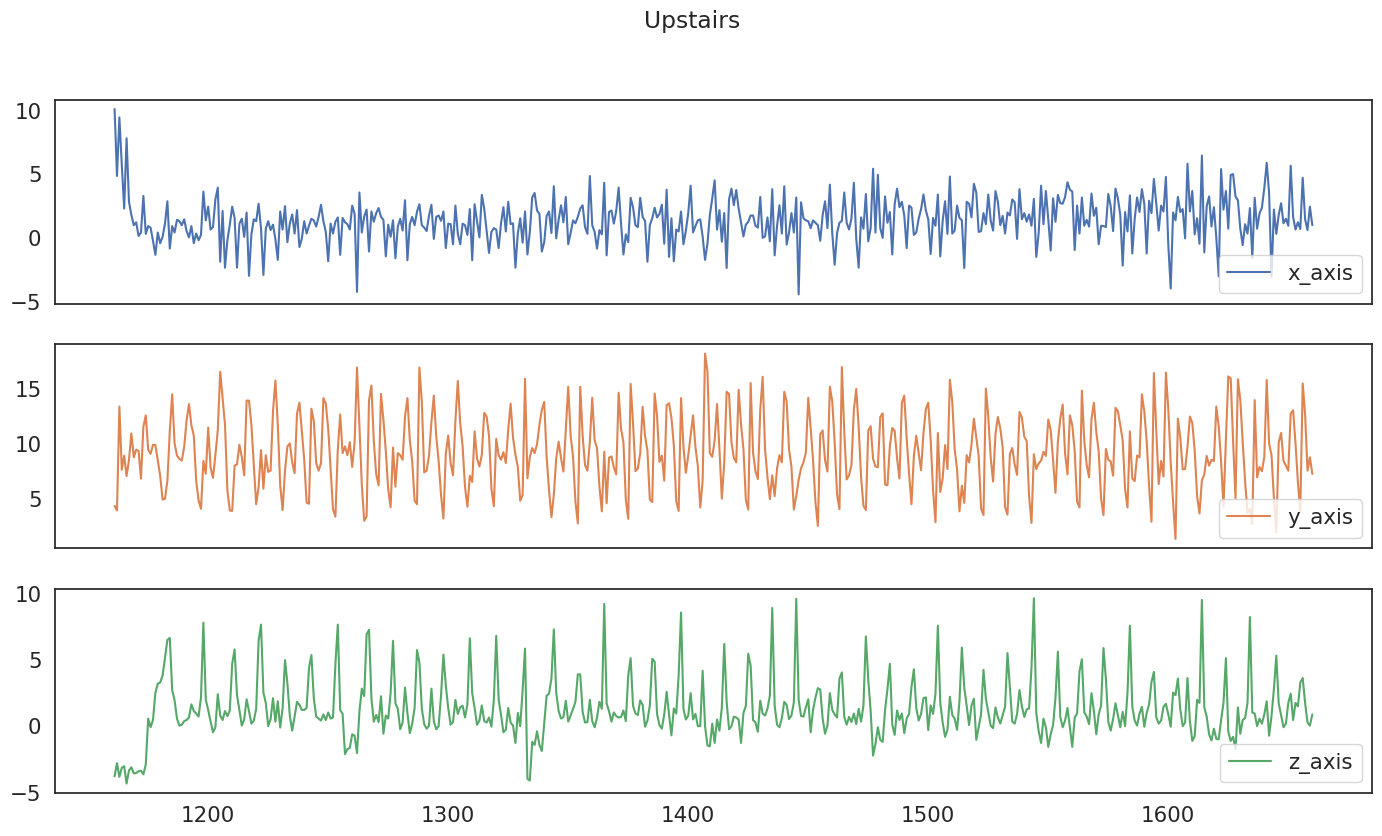

In [11]:
# Inspect the sensor data for the activity "Upstairs"
inspect_activity("Upstairs", df)

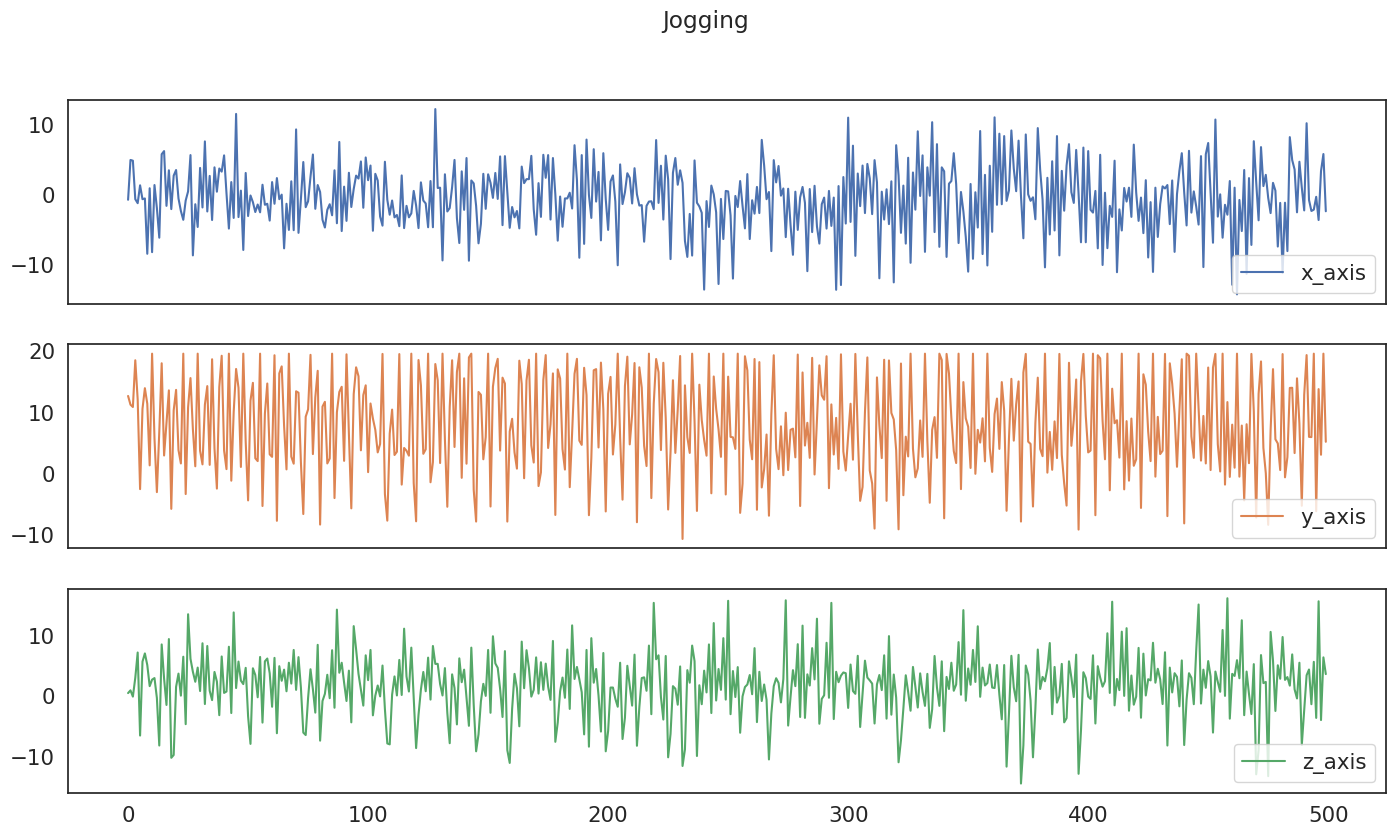

In [12]:
# Inspect the sensor data for the activity "Jogging"
inspect_activity("Jogging", df)

The dataset is composed of 179 different activity executions


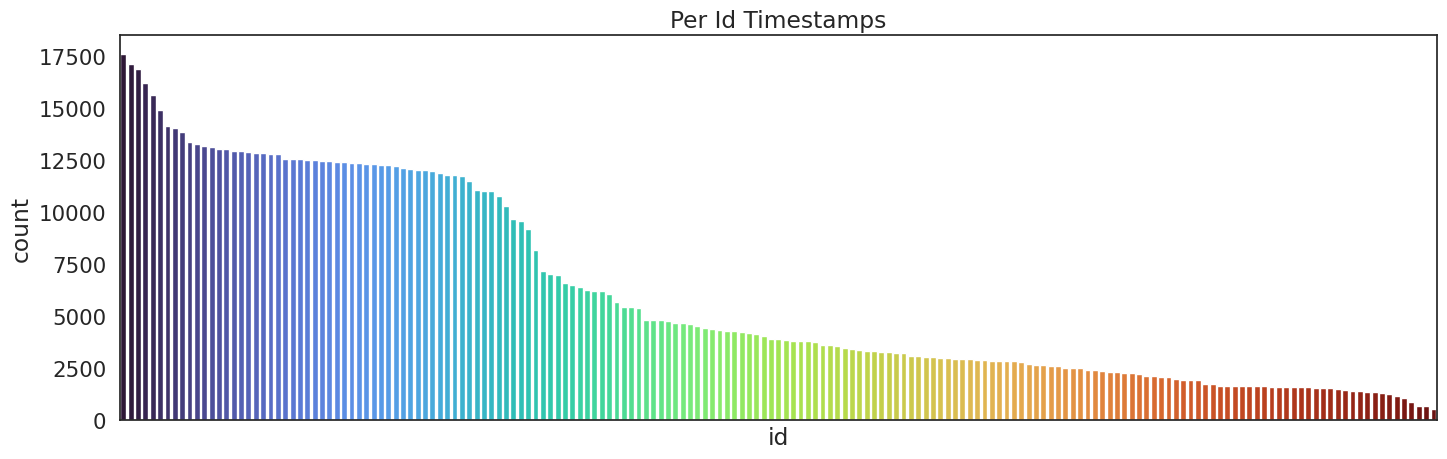

In [13]:
# Identify unique activity executions per user by creating a composite ID
df['id'] = df['user_id'].astype('str') + '_' + df['activity'].astype('str')

# Print the number of unique activity executions
print(f'The dataset is composed of {df["id"].nunique()} different activity executions')

# Count the unique IDs for distinct activity executions
n_users = len(df['id'].unique())

# Create a custom colour map for better distinction of unique IDs
colors = plt.cm.turbo(np.linspace(0, 1, n_users))

# Visualise the count of timestamps per unique ID
plt.figure(figsize=(17, 5))
sns.countplot(
    x='id',
    data=df,
    order=df['id'].value_counts().index,
    palette=colors
)

# Set the title of the plot and disable x-axis labels for clarity
plt.title('Per Id Timestamps')
plt.xticks([], [])  # Remove x-axis ticks and labels

# Display the plot
plt.show()

In [14]:
# Display the first five rows of the DataFrame
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,id
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,33_Jogging
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,33_Jogging
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,33_Jogging
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,33_Jogging
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,33_Jogging


In [15]:
# Split the dataset into training, validation, and test sets based on user ID
df_train = df[df['user_id'] <= 26]  # Training set: user IDs 1 to 26
df_val = df[(df['user_id'] > 26) & (df['user_id'] <= 31)]  # Validation set: user IDs 27 to 31
df_test = df[df['user_id'] > 31]  # Test set: user IDs 32 and above

# Print the shapes of the training, validation, and test sets
df_train.shape, df_val.shape, df_test.shape

((778467, 7), (164179, 7), (155562, 7))

In [16]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'Walking': 0,
    'Jogging': 0,
    'Upstairs': 0,
    'Downstairs': 0,
    'Sitting': 0,
    'Standing': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['id'].unique():
    label = df_train[df_train['id'] == id]['activity'].values[0]
    training_labels[label] += 1

# Print the distribution of training labels
print('Training labels:', training_labels)

Training labels: {'Walking': 26, 'Jogging': 24, 'Upstairs': 23, 'Downstairs': 23, 'Sitting': 14, 'Standing': 14}


In [17]:
# Initialise a dictionary to count occurrences of each activity in the validation set
val_labels = {
    'Walking': 0,
    'Jogging': 0,
    'Upstairs': 0,
    'Downstairs': 0,
    'Sitting': 0,
    'Standing': 0
}

# Count occurrences of each activity for unique IDs in the validation set
for id in df_val['id'].unique():
    label = df_val[df_val['id'] == id]['activity'].values[0]
    val_labels[label] += 1

# Print the distribution of validation labels
print('Validation labels:', val_labels)

Validation labels: {'Walking': 5, 'Jogging': 3, 'Upstairs': 5, 'Downstairs': 5, 'Sitting': 4, 'Standing': 5}


In [18]:
# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'Walking': 0,
    'Jogging': 0,
    'Upstairs': 0,
    'Downstairs': 0,
    'Sitting': 0,
    'Standing': 0
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['id'].unique():
    label = df_test[df_test['id'] == id]['activity'].values[0]
    test_labels[label] += 1

# Print the distribution of test labels
print('Test labels:', test_labels)

Test labels: {'Walking': 5, 'Jogging': 5, 'Upstairs': 4, 'Downstairs': 4, 'Sitting': 5, 'Standing': 5}


In [19]:
# Define a mapping of activity names to integer labels
label_mapping = {
    'Walking': 0,
    'Jogging': 1,
    'Upstairs': 2,
    'Downstairs': 3,
    'Sitting': 4,
    'Standing': 5
}

# Map activity names to integers in the training set
df_train['activity'] = df_train['activity'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['activity'] = df_val['activity'].map(label_mapping)

# Map activity names to integers in the test set
df_test['activity'] = df_test['activity'].map(label_mapping)

In [20]:
# Define the columns to be normalised
scale_columns = ['x_axis', 'y_axis', 'z_axis']

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])

    # Normalise the validation set
    df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])

    # Normalise the test set
    df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column])

In [21]:
# Display the first five rows of the training DataFrame
df_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,id
8489,17,0,57869902574000,0.510163,0.741908,0.488932,17_Walking
8490,17,0,57870012316000,0.495703,0.751526,0.487895,17_Walking
8491,17,0,57870122301000,0.489850,0.742938,0.484785,17_Walking
8492,17,0,57870222246000,0.499490,0.748778,0.489623,17_Walking
8493,17,0,57870332292000,0.499490,0.750496,0.486858,17_Walking


In [22]:
# Define the window size
window = 200

# Define the stride for overlapping windows
stride = 50

In [23]:
# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['id'].unique():
        # Extract sensor data for the current ID
        temp = df[df['id'] == id][['x_axis', 'y_axis', 'z_axis']].values

        # Retrieve the activity label for the current ID
        label = df[df['id'] == id]['activity'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, 3), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [24]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, window, stride)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, window, stride)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, window, stride)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15464, 200, 3), (15464,), (3259, 200, 3), (3259,), (3084, 200, 3), (3084,))

In [25]:
# Convert sparse labels to categorical values for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

# Print the shapes of the datasets and their corresponding categorical labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15464, 200, 3),
 (15464, 6),
 (3259, 200, 3),
 (3259, 6),
 (3084, 200, 3),
 (3084, 6))

In [26]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
classes = y_train.shape[-1]

# Set the batch size for training
batch_size = 128

# Set the number of epochs for training
epochs = 200

## 🛠️ Long Short Term Memory (LSTM)

<img src="https://drive.google.com/uc?export=view&id=15lVxI3bwelzoFkeC0g4OJsAsH1nedJx4" width="700"/>

<img src="https://drive.google.com/uc?export=view&id=1AHDpl1vMWow9xUhP4C7nZLJjk_kNos_I" width="700"/>

In [27]:
# Define a function to build an LSTM-based classifier
def build_LSTM_classifier(input_shape, classes):
    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Add feature extractor layers
    x = tfkl.LSTM(128, return_sequences=True, name='lstm_0')(input_layer)
    x = tfkl.BatchNormalization(name='batch_norm_0')(x)

    x = tfkl.LSTM(128, return_sequences=True, name='lstm_1')(x)
    x = tfkl.BatchNormalization(name='batch_norm_1')(x)

    x = tfkl.LSTM(128, name='lstm_2')(x)
    x = tfkl.BatchNormalization(name='batch_norm_2')(x)

    # Add dropout for regularisation
    x = tfkl.Dropout(0.5, name='dropout')(x)

    # Add classifier layers
    x = tfkl.Dense(128, name='dense_hidden')(x)
    x = tfkl.BatchNormalization(name='dense_hidden_batch_norm')(x)
    x = tfkl.Activation('relu', name='dense_hidden_activation')(x)

    x = tfkl.Dense(classes, name='dense_output')(x)
    output_layer = tfkl.Activation('softmax', name='dense_output_activation')(x)

    # Create the model by connecting input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with categorical crossentropy loss and Adam optimiser
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=['accuracy']
    )

    # Return the compiled model
    return model


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 200, 3)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lstm_0 (LSTM)                       │ (None, 200, 128)             │        67,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_0 (BatchNormalization)   │ (None, 200, 128)             │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lstm_1 (LSTM)                       │ (None, 200, 128)             │       131,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_1 (BatchNormalization)   │ (None, 200, 128)             │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lstm_2 (LSTM)                       │ (None, 128)                  │       131,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_2 (BatchNormalization)   │ (None, 128)                  │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden (Dense)                │ (None, 128)                  │        16,512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden_batch_norm             │ (None, 128)                  │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden_activation             │ (None, 128)                  │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_output (Dense)                │ (None, 6)                    │           774 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_output_activation             │ (None, 6)                    │             0 │    -    │
│ (Activation)                        │                              │               │         │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 350,086 (1.34 MB)

 Trainable params: 349,062 (1.33 MB)

 Non-trainable params: 1,024 (4.00 KB)

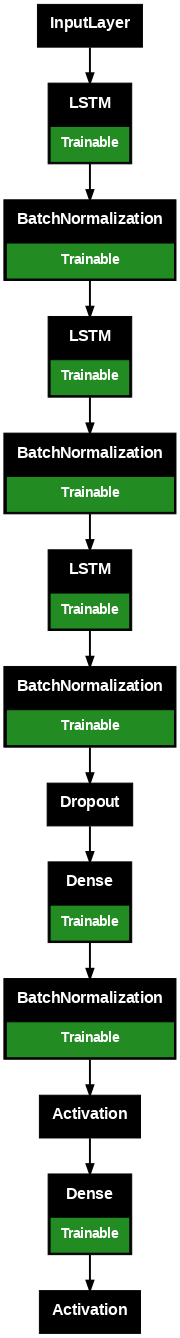

In [28]:
# Build the LSTM classifier model
model = build_LSTM_classifier(input_shape, classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [29]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'LSTM_Activity_Classifier_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.5970 - loss: 1.1792 - val_accuracy: 0.4839 - val_loss: 1.6745 - learning_rate: 0.0010
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7911 - loss: 0.6136 - val_accuracy: 0.0693 - val_loss: 4.1858 - learning_rate: 0.0010
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8359 - loss: 0.4688 - val_accuracy: 0.3237 - val_loss: 3.0034 - learning_rate: 0.0010
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8773 - loss: 0.3372 - val_accuracy: 0.2292 - val_loss: 2.7659 - learning_rate: 0.0010
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9060 - loss: 0.2672 - val_accuracy: 0.6793 - val_loss: 1.3043 - learning_rate: 0.0010
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9408 - loss: 0.1871 - val_accuracy: 0.1175 - val_loss: 4.5886 - learning_rate: 0.0010
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9454 - 

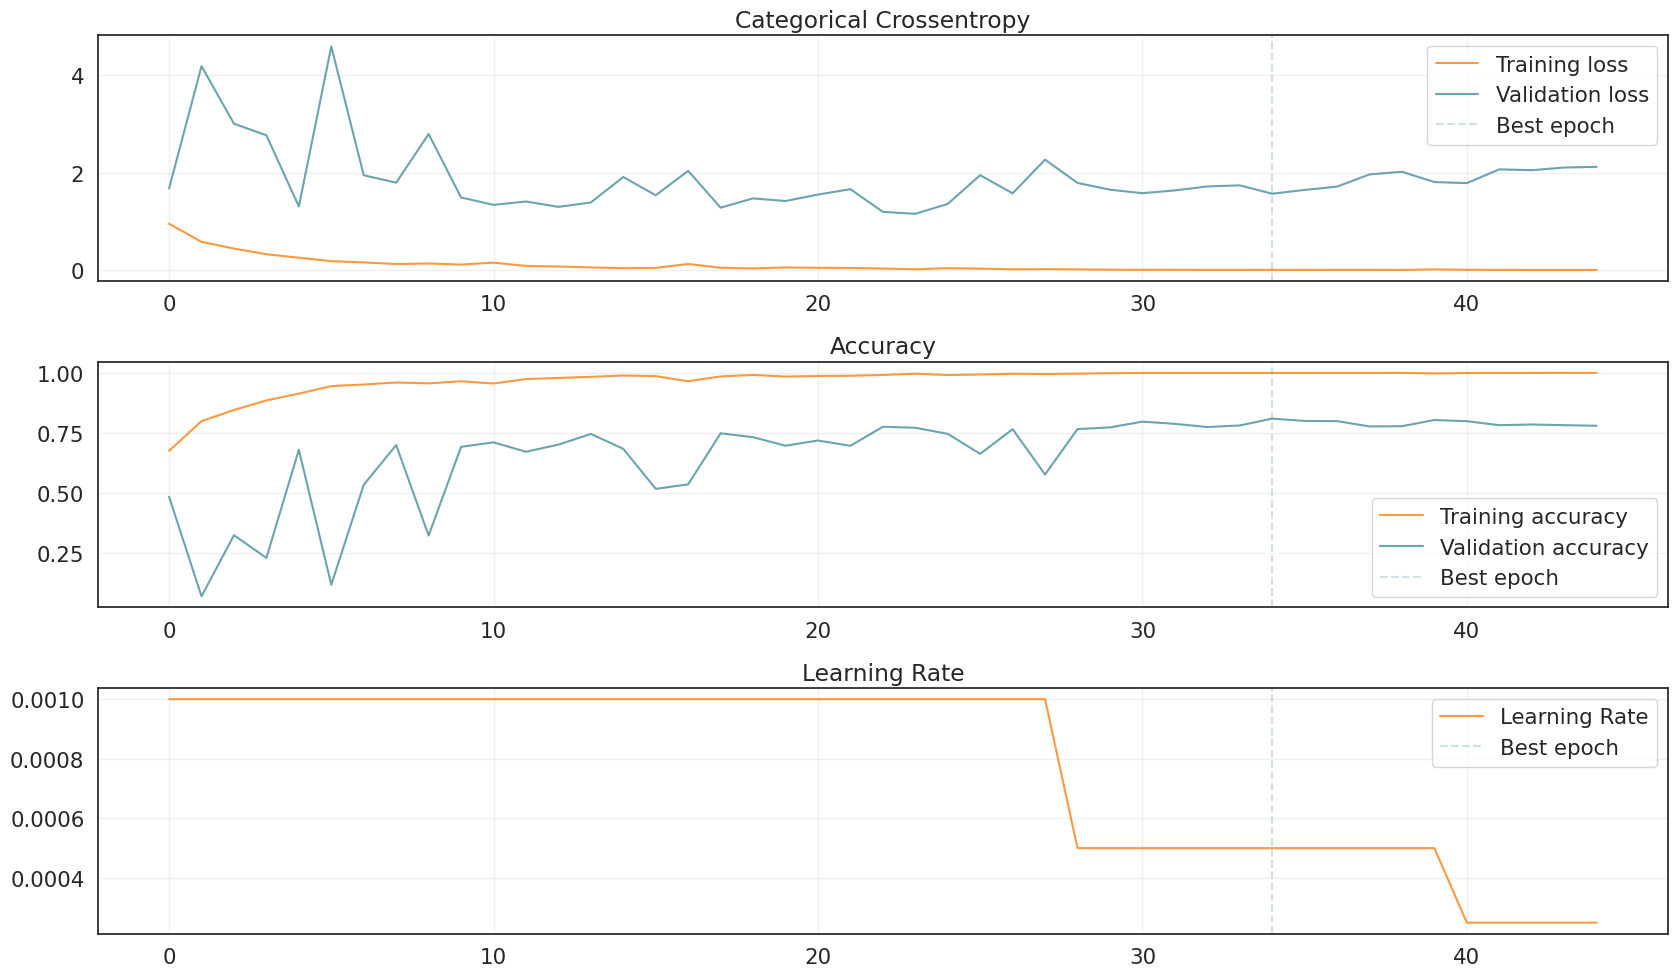

In [30]:
# Identify the epoch with the best validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Create a figure with 3 vertical subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(17, 10), height_ratios=[1, 1, 1])

# Plot 1: Loss
ax1.plot(history['loss'], label='Training loss', alpha=0.8, color='#ff7f0e')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#5a9aa5')
ax1.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=0.8, color='#ff7f0e')
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=0.9, color='#5a9aa5')
ax2.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Learning Rate
ax3.plot(history['learning_rate'], label='Learning Rate', alpha=0.8, color='#ff7f0e')
ax3.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax3.set_title('Learning Rate')
ax3.legend()
ax3.grid(alpha=0.3)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## 🕹️ Use the Model - Make Inference

Accuracy: 0.9183
Precision: 0.888
Recall: 0.9145
F1: 0.8965


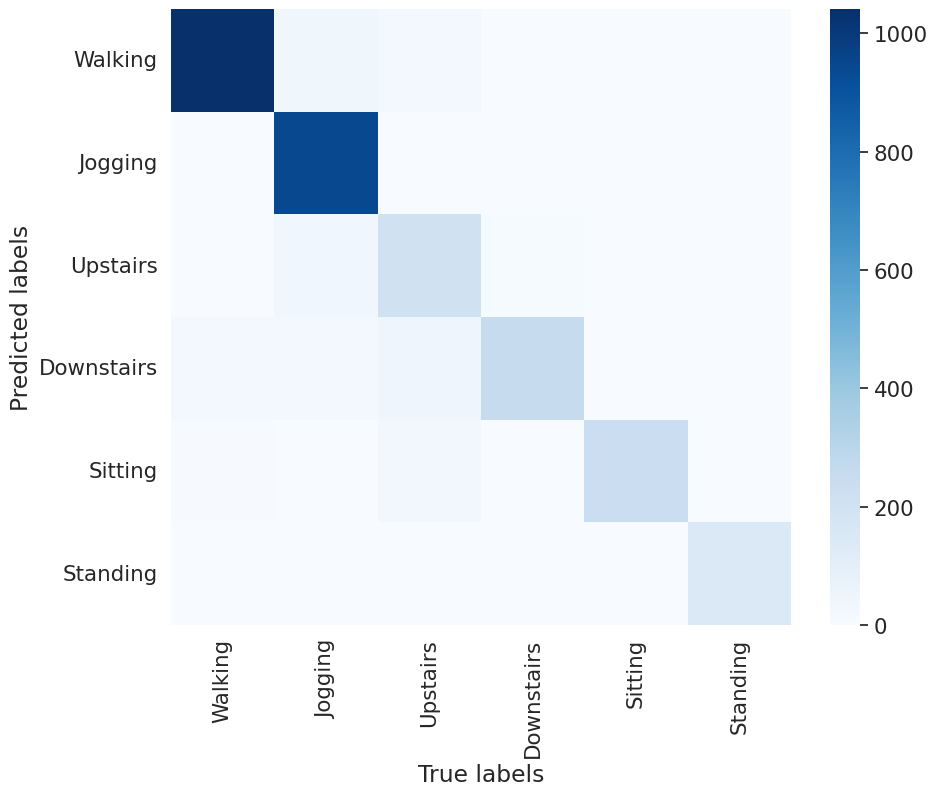

In [32]:
# Predict the test set with the LSTM
model = tfk.models.load_model('LSTM_Activity_Classifier_80.91.keras')
predictions = model.predict(X_test, verbose=0)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',round(accuracy,4))
print('Precision:',round(precision,4))
print('Recall:',round(recall,4))
print('F1:',round(f1,4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 🛠️ Bidirectional Long Short Term Memory (LSTM)

<img src="https://drive.google.com/uc?export=view&id=1qdoADEtAah2eXNcyoqVz6yO9W_6LmJ9x" width="700"/>

In [33]:
# Define a function to build an BiLSTM-based classifier
def build_BiLSTM_classifier(input_shape, classes):
    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Add feature extractor layers with bidirectional LSTM layers
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True), name='bilstm_0')(input_layer)
    x = tfkl.BatchNormalization(name='batch_norm_0')(x)

    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True), name='bilstm_1')(x)
    x = tfkl.BatchNormalization(name='batch_norm_1')(x)

    x = tfkl.Bidirectional(tfkl.LSTM(128), name='bilstm_2')(x)
    x = tfkl.BatchNormalization(name='batch_norm_2')(x)

    x = tfkl.Dropout(0.5, name='dropout')(x)  # Add dropout for regularisation

    # Add classifier layers
    x = tfkl.Dense(128, name='dense_hidden')(x)
    x = tfkl.BatchNormalization(name='dense_hidden_batch_norm')(x)
    x = tfkl.Activation('relu', name='dense_hidden_activation')(x)

    x = tfkl.Dense(classes, name='dense_output')(x)
    output_layer = tfkl.Activation('softmax', name='dense_output_activation')(x)

    # Create the model by connecting input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with categorical crossentropy loss and Adam optimiser
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=['accuracy']
    )

    # Return the compiled model
    return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 200, 3)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ bilstm_0 (Bidirectional)            │ (None, 200, 256)             │       135,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_0 (BatchNormalization)   │ (None, 200, 256)             │         1,024 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ bilstm_1 (Bidirectional)            │ (None, 200, 256)             │       394,240 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_1 (BatchNormalization)   │ (None, 200, 256)             │         1,024 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ bilstm_2 (Bidirectional)            │ (None, 256)                  │       394,240 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_2 (BatchNormalization)   │ (None, 256)                  │         1,024 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden (Dense)                │ (None, 128)                  │        32,896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden_batch_norm             │ (None, 128)                  │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden_activation             │ (None, 128)                  │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_output (Dense)                │ (None, 6)                    │           774 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_output_activation             │ (None, 6)                    │             0 │    -    │
│ (Activation)                        │                              │               │         │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 960,902 (3.67 MB)

 Trainable params: 959,110 (3.66 MB)

 Non-trainable params: 1,792 (7.00 KB)

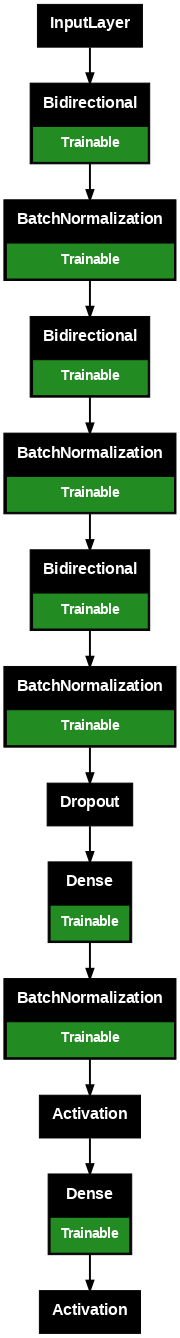

In [34]:
# Build the BiLSTM classifier model
model = build_BiLSTM_classifier(input_shape, classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [35]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BiLSTM_Activity_Classifier_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6207 - loss: 1.0842 - val_accuracy: 0.5885 - val_loss: 1.6063 - learning_rate: 0.0010
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.7757 - loss: 0.6315 - val_accuracy: 0.4284 - val_loss: 1.8509 - learning_rate: 0.0010
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.8318 - loss: 0.4639 - val_accuracy: 0.1878 - val_loss: 2.9284 - learning_rate: 0.0010
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.8778 - loss: 0.3314 - val_accuracy: 0.3295 - val_loss: 2.3105 - learning_rate: 0.0010
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.9196 - loss: 0.2254 - val_accuracy: 0.6867 - val_loss: 1.4733 - learning_rate: 0.0010
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9484 - loss: 0.1583 - val_accuracy: 0.4465 - val_loss: 2.6557 - learning_rate: 0.0010
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accura

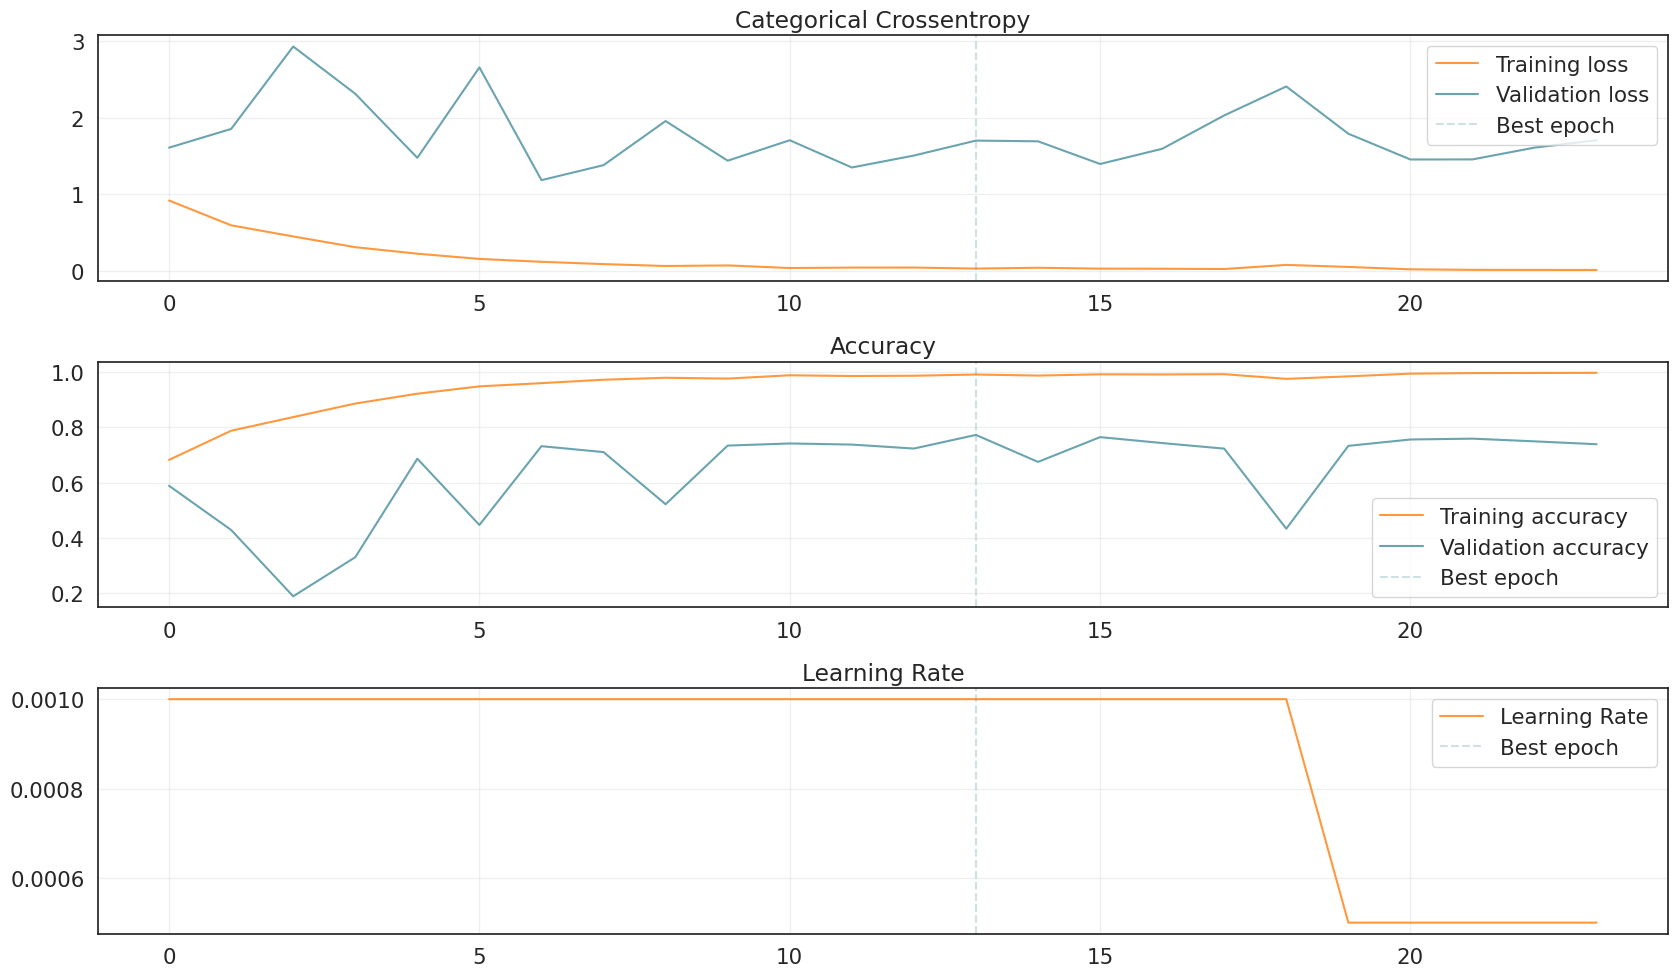

In [36]:
# Identify the epoch with the best validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Create a figure with 3 vertical subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(17, 10), height_ratios=[1, 1, 1])

# Plot 1: Loss
ax1.plot(history['loss'], label='Training loss', alpha=0.8, color='#ff7f0e')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#5a9aa5')
ax1.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=0.8, color='#ff7f0e')
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=0.9, color='#5a9aa5')
ax2.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Learning Rate
ax3.plot(history['learning_rate'], label='Learning Rate', alpha=0.8, color='#ff7f0e')
ax3.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax3.set_title('Learning Rate')
ax3.legend()
ax3.grid(alpha=0.3)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## 🕹️ Use the Model - Make Inference

Accuracy: 0.9154
Precision: 0.8984
Recall: 0.8927
F1: 0.8942


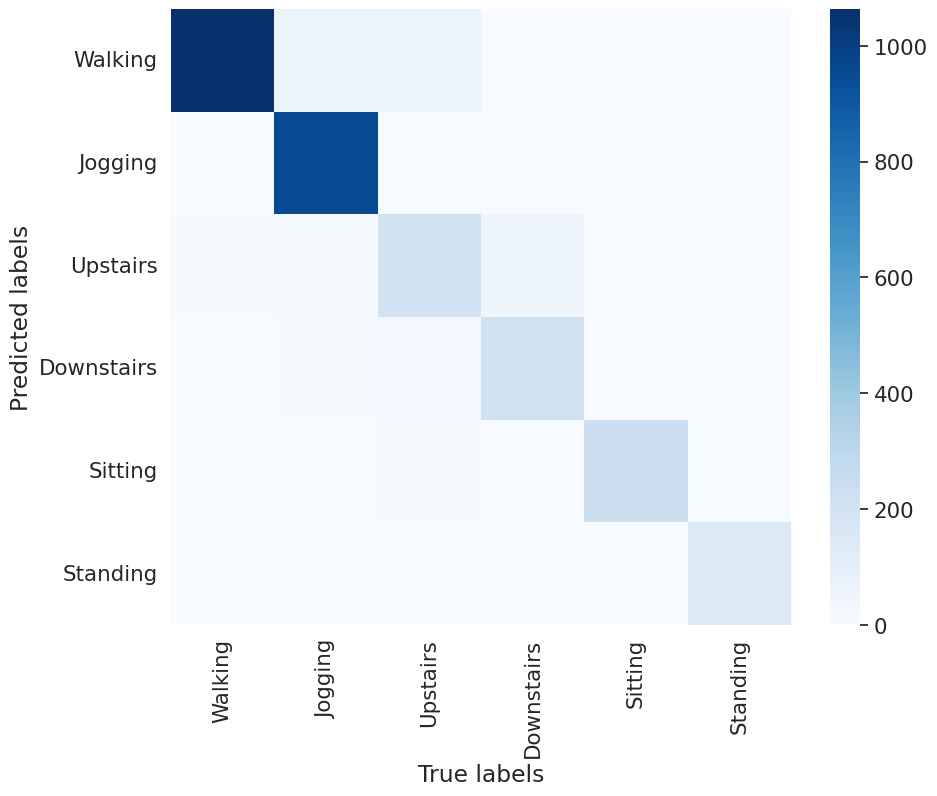

In [38]:
# Predict the test set with the LSTM
model = tfk.models.load_model('BiLSTM_Activity_Classifier_77.29.keras')
predictions = model.predict(X_test, verbose=0)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',round(accuracy,4))
print('Precision:',round(precision,4))
print('Recall:',round(recall,4))
print('F1:',round(f1,4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 🛠️  1D Convolutional Neural Network

<img src="https://drive.google.com/uc?export=view&id=1tDfP6Jp2EJvILij8pY8KR_IRNjx3vD93" width="700"/>

In [39]:
# Define a function to build a 1D CNN-based classifier
def build_1DCNN_classifier(input_shape, classes):
    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Add feature extractor layers
    x = tfkl.Conv1D(128, 3, padding='same', name='conv1d_0')(input_layer)
    x = tfkl.BatchNormalization(name='batch_norm_0')(x)
    x = tfkl.Activation('relu', name='activation_0')(x)
    x = tfkl.MaxPooling1D(name='max_pooling_0')(x)

    x = tfkl.Conv1D(128, 3, padding='same', name='conv1d_1')(x)
    x = tfkl.BatchNormalization(name='batch_norm_1')(x)
    x = tfkl.Activation('relu', name='activation_1')(x)
    x = tfkl.MaxPooling1D(name='max_pooling_1')(x)

    x = tfkl.Conv1D(128, 3, padding='same', name='conv1d_2')(x)
    x = tfkl.BatchNormalization(name='batch_norm_2')(x)
    x = tfkl.Activation('relu', name='activation_2')(x)
    x = tfkl.GlobalAveragePooling1D(name='gap')(x)

    # Add dropout for regularisation
    x = tfkl.Dropout(0.5, name='dropout')(x)

    # Add classifier layers
    x = tfkl.Dense(128, name='dense_hidden')(x)
    x = tfkl.BatchNormalization(name='dense_hidden_batch_norm')(x)
    x = tfkl.Activation('relu', name='dense_hidden_activation')(x)

    x = tfkl.Dense(classes, name='dense_output')(x)
    output_layer = tfkl.Activation('softmax', name='dense_output_activation')(x)

    # Create the model by connecting input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with categorical crossentropy loss and Adam optimiser
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=['accuracy']
    )

    # Return the compiled model
    return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 200, 3)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1d_0 (Conv1D)                   │ (None, 200, 128)             │         1,280 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_0 (BatchNormalization)   │ (None, 200, 128)             │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_0 (Activation)           │ (None, 200, 128)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling_0 (MaxPooling1D)        │ (None, 100, 128)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1d_1 (Conv1D)                   │ (None, 100, 128)             │        49,280 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_1 (BatchNormalization)   │ (None, 100, 128)             │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_1 (Activation)           │ (None, 100, 128)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling_1 (MaxPooling1D)        │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1d_2 (Conv1D)                   │ (None, 50, 128)              │        49,280 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_2 (BatchNormalization)   │ (None, 50, 128)              │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_2 (Activation)           │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ gap (GlobalAveragePooling1D)        │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden (Dense)                │ (None, 128)                  │        16,512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden_batch_norm             │ (None, 128)                  │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_hidden_activation             │ (None, 128)                  │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_output (Dense)                │ (None, 6)                    │           774 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_output_activati

 Total params: 119,174 (465.52 KB)

 Trainable params: 118,150 (461.52 KB)

 Non-trainable params: 1,024 (4.00 KB)

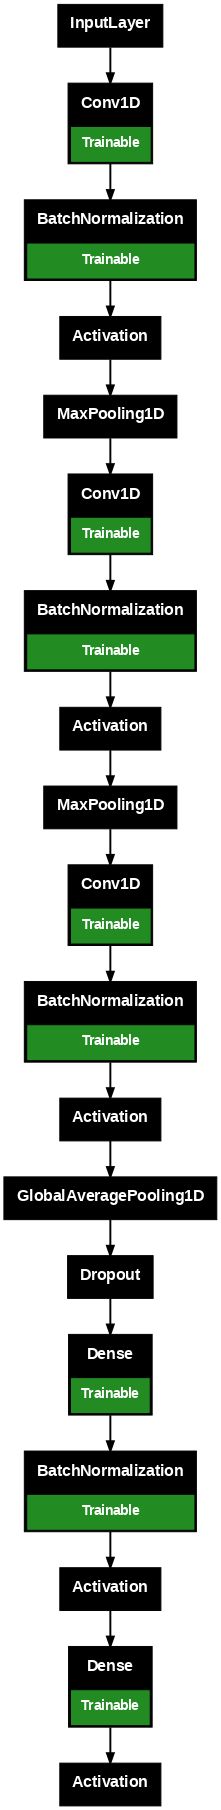

In [40]:
# Build the 1D CNN classifier model
model = build_1DCNN_classifier(input_shape, classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [41]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = '1DCNN_Activity_Classifier_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.7367 - loss: 0.7495 - val_accuracy: 0.0629 - val_loss: 4.1696 - learning_rate: 0.0010
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9259 - loss: 0.2155 - val_accuracy: 0.0629 - val_loss: 6.3312 - learning_rate: 0.0010
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9600 - loss: 0.1223 - val_accuracy: 0.0764 - val_loss: 4.5134 - learning_rate: 0.0010
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9731 - loss: 0.0841 - val_accuracy: 0.2795 - val_loss: 2.9007 - learning_rate: 0.0010
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9764 - loss: 0.0709 - val_accuracy: 0.3176 - val_loss: 2.3886 - learning_rate: 0.0010
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9809 - loss: 0.0559 - val_accuracy: 0.7383 - val_loss: 1.1540 - learning_rate: 0.0010
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9868 - loss: 

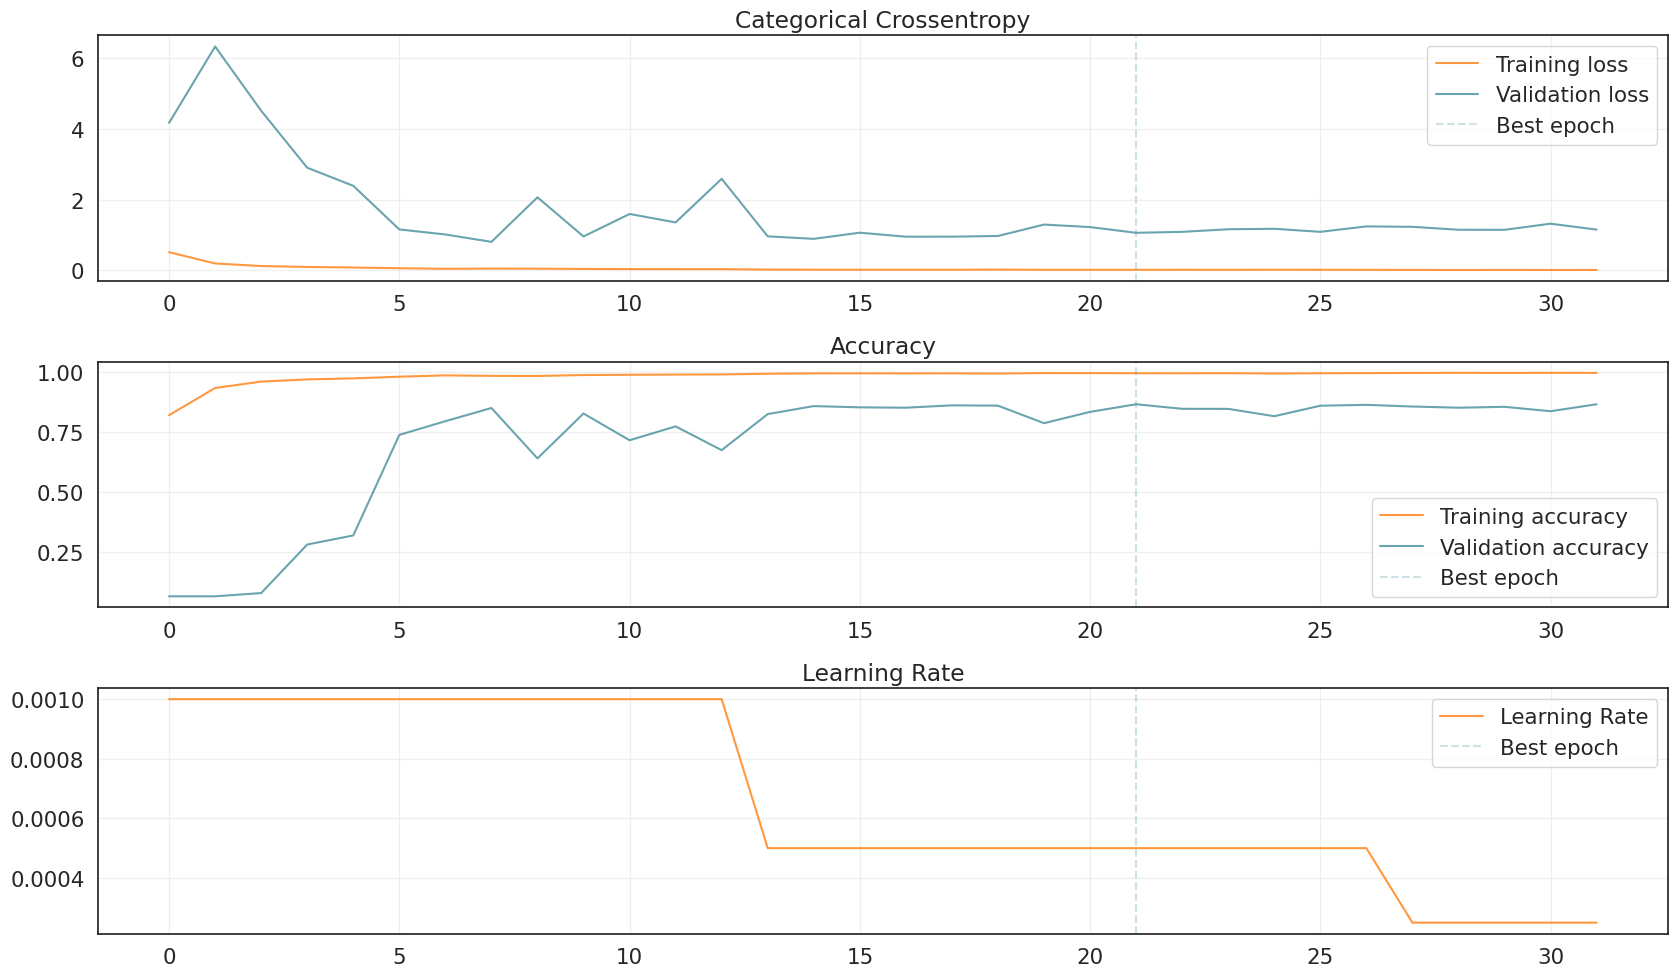

In [42]:
# Identify the epoch with the best validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Create a figure with 3 vertical subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(17, 10), height_ratios=[1, 1, 1])

# Plot 1: Loss
ax1.plot(history['loss'], label='Training loss', alpha=0.8, color='#ff7f0e')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#5a9aa5')
ax1.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=0.8, color='#ff7f0e')
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=0.9, color='#5a9aa5')
ax2.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Learning Rate
ax3.plot(history['learning_rate'], label='Learning Rate', alpha=0.8, color='#ff7f0e')
ax3.axvline(x=best_epoch, label='Best epoch', alpha=0.3, linestyle='--', color='#5a9aa5')
ax3.set_title('Learning Rate')
ax3.legend()
ax3.grid(alpha=0.3)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## 🕹️ Use the Model - Make Inference

Accuracy: 0.9394
Precision: 0.9166
Recall: 0.9043
F1: 0.9088


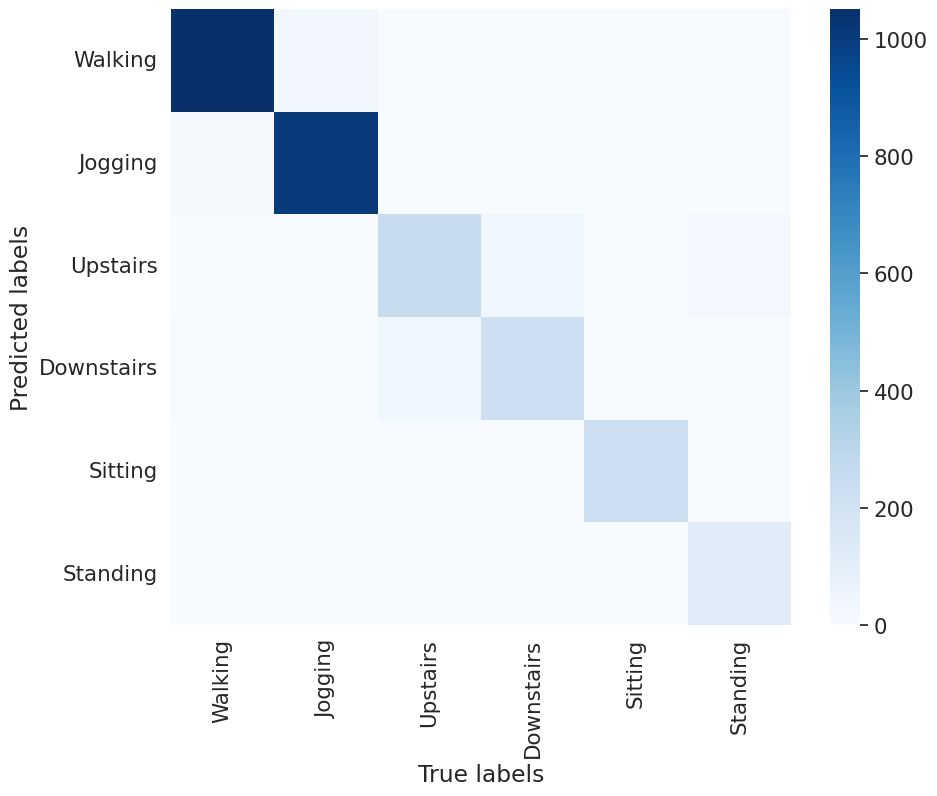

In [44]:
# Predict the test set with the LSTM
model = tfk.models.load_model('1DCNN_Activity_Classifier_86.65.keras')
predictions = model.predict(X_test, verbose=0)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',round(accuracy,4))
print('Precision:',round(precision,4))
print('Recall:',round(recall,4))
print('F1:',round(f1,4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()